In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor


# Load the datasets
data = pd.read_csv("../data/owid-co2-data.csv")
codebook = pd.read_csv("../data/owid-co2-codebook.csv")


FileNotFoundError: [Errno 2] No such file or directory: '../data/owid-co2-data.csv'

In [3]:
# --- BASIC OVERVIEW ---
print("=== Basic Info ===")
print("Shape:", data.shape)
print("Columns:", list(data.columns))
print("Year Range:", data['year'].min(), "-", data['year'].max())
print("Number of countries/entities:", data['country'].nunique())
print("Sample countries:", data['country'].unique())

# --- DATA TYPES AND NULLS ---
print("\n=== Data Types ===")
print(data.dtypes)

print("\n=== Missing Values ===")
missing = data.isnull().sum()
print(missing[missing > 0].sort_values(ascending=False))

# --- SUMMARY STATISTICS ---
print("\n=== Summary Statistics ===")
print(data.describe(include='all'))

=== Basic Info ===
Shape: (50191, 79)
Columns: ['country', 'year', 'iso_code', 'population', 'gdp', 'cement_co2', 'cement_co2_per_capita', 'co2', 'co2_growth_abs', 'co2_growth_prct', 'co2_including_luc', 'co2_including_luc_growth_abs', 'co2_including_luc_growth_prct', 'co2_including_luc_per_capita', 'co2_including_luc_per_gdp', 'co2_including_luc_per_unit_energy', 'co2_per_capita', 'co2_per_gdp', 'co2_per_unit_energy', 'coal_co2', 'coal_co2_per_capita', 'consumption_co2', 'consumption_co2_per_capita', 'consumption_co2_per_gdp', 'cumulative_cement_co2', 'cumulative_co2', 'cumulative_co2_including_luc', 'cumulative_coal_co2', 'cumulative_flaring_co2', 'cumulative_gas_co2', 'cumulative_luc_co2', 'cumulative_oil_co2', 'cumulative_other_co2', 'energy_per_capita', 'energy_per_gdp', 'flaring_co2', 'flaring_co2_per_capita', 'gas_co2', 'gas_co2_per_capita', 'ghg_excluding_lucf_per_capita', 'ghg_per_capita', 'land_use_change_co2', 'land_use_change_co2_per_capita', 'methane', 'methane_per_capita'

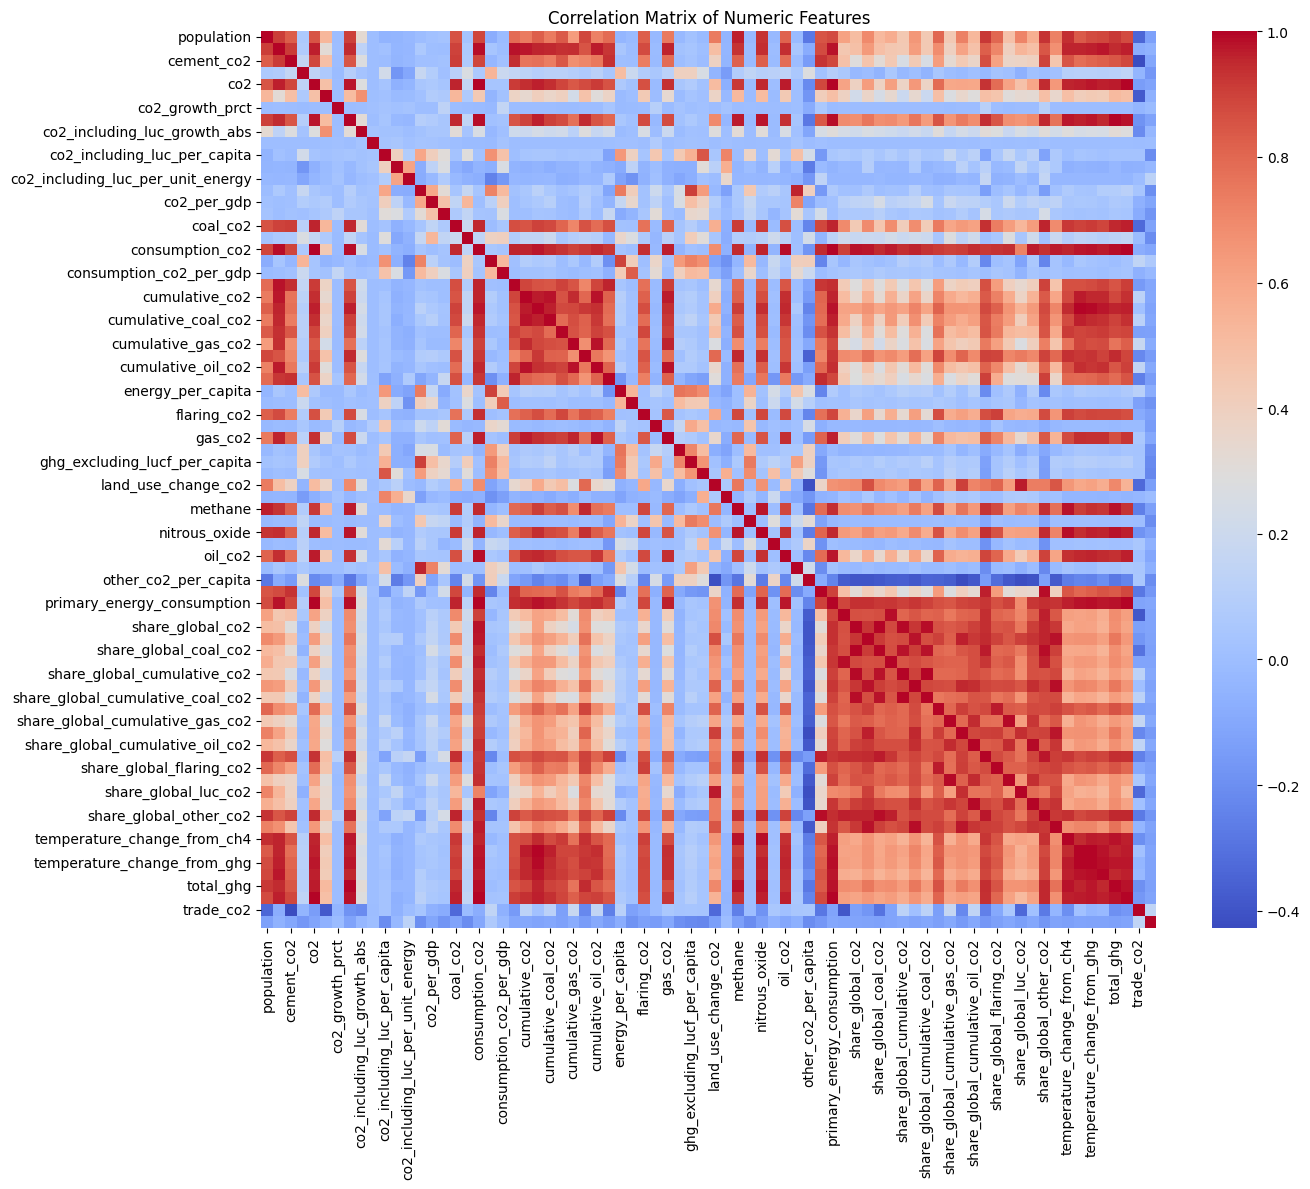

In [4]:
# === CORRELATION MATRIX ===
numeric_cols = data.select_dtypes(include='number').drop(columns=['year'], errors='ignore')
corr = numeric_cols.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()

# Save or show
os.makedirs("../outputs", exist_ok=True)
plt.savefig("../outputs/correlation_matrix.png")
plt.show()

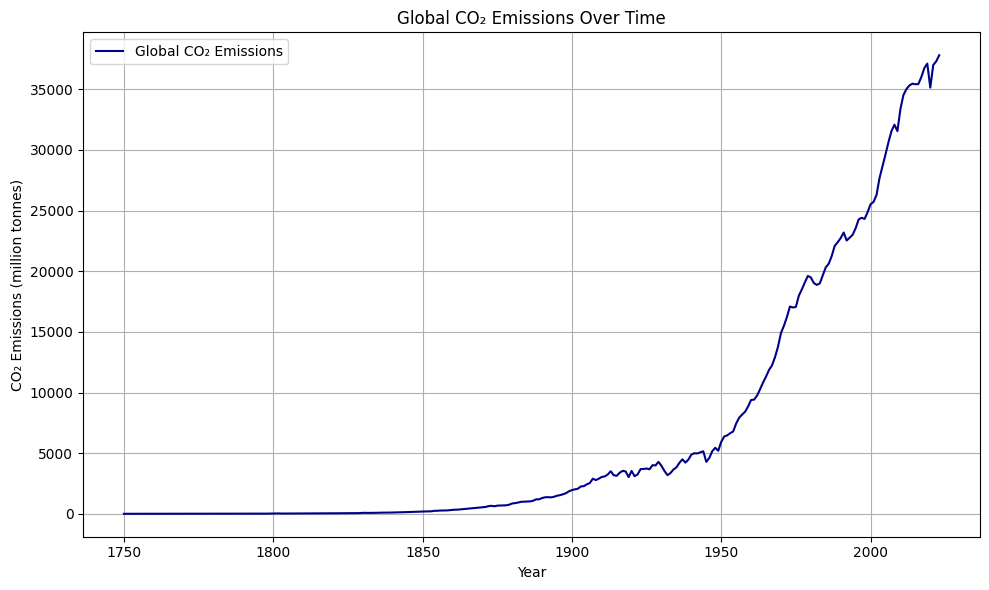

C:\Users\acksh\AppData\Local\Temp\ipykernel_26392\2337652467.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_emitters, x='co2', y='country', palette='Reds_r')


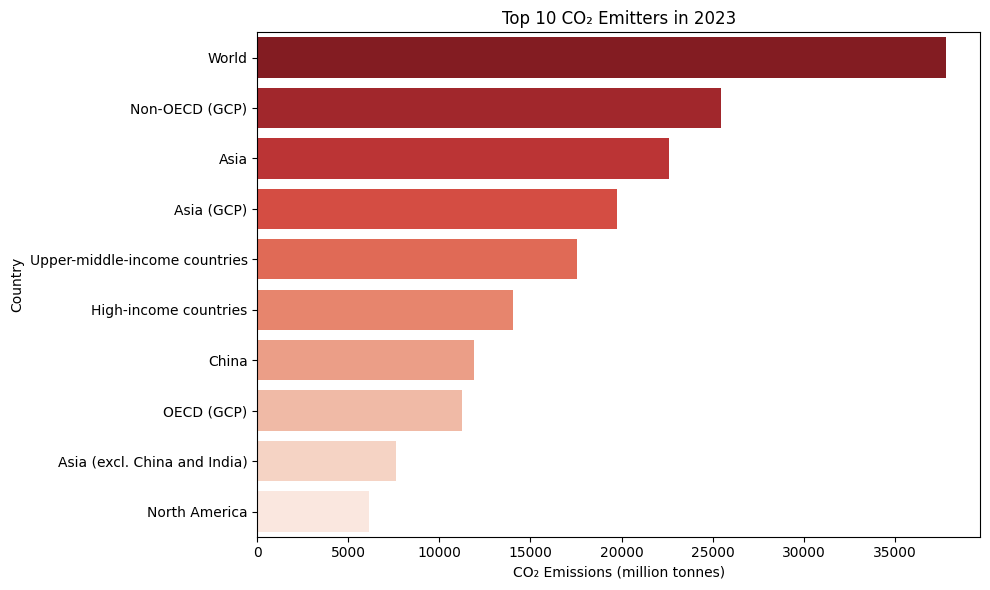

In [5]:
# === GLOBAL CO2 TREND ===
world_data = data[data['country'] == 'World']

plt.figure(figsize=(10, 6))
plt.plot(world_data['year'], world_data['co2'], label='Global CO₂ Emissions', color='darkblue')
plt.title("Global CO₂ Emissions Over Time")
plt.xlabel("Year")
plt.ylabel("CO₂ Emissions (million tonnes)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("../outputs/global_co2_trend.png")
plt.show()

# === TOP 10 EMITTERS IN THE LATEST YEAR ===
latest_year = data['year'].max()
top_emitters = data[(data['year'] == latest_year) & (data['country'].str.len() <= 56)]
top_emitters = top_emitters.sort_values(by='co2', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_emitters, x='co2', y='country', palette='Reds_r')
plt.title(f"Top 10 CO₂ Emitters in {latest_year}")
plt.xlabel("CO₂ Emissions (million tonnes)")
plt.ylabel("Country")
plt.tight_layout()
plt.savefig("../outputs/top_emitters.png")
plt.show()

In [3]:
csv_file = r"C:\Users\acksh\OneDrive\Desktop\MSAI\Machine Learning\Final_project\data\raw_data\databycountry\United_States.csv"

def analyze_selected_features(csv_file, feature_columns, target_variable, correlation_threshold=0.8):
    # Load data and select columns
    df = pd.read_csv(csv_file)
    columns_to_use = feature_columns + [target_variable]
    df_selected = df[columns_to_use].copy()
    
    # Drop rows with NaN in target
    df_selected = df_selected.dropna(subset=[target_variable])
    
    # Plot correlation matrix
    plt.figure(figsize=(20, 16))
    corr_matrix = df_selected.corr()
    
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5,annot_kws={"size": 6})
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.savefig('..//outputs/new_correlation_matrix.png')
    plt.show()
    
    # Find correlated pairs
    correlated_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) >= correlation_threshold:
                correlated_pairs.append((corr_matrix.columns[i], 
                                        corr_matrix.columns[j], 
                                        corr_matrix.iloc[i, j]))
    
    correlated_df = pd.DataFrame(correlated_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])
    correlated_df = correlated_df.sort_values('Correlation', ascending=False)
    print("Highly correlated feature pairs:")
    print(correlated_df)
    
    # Calculate VIF
    X = df_selected.drop(columns=[target_variable])
    X = X.fillna(X.mean())  # Handle any remaining NaN values
    
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif_data = vif_data.sort_values("VIF", ascending=False)
    print("\nVariance Inflation Factors:")
    print(vif_data)
    
    # Feature importance
    X = df_selected.drop(columns=[target_variable])
    y = df_selected[target_variable]
    
    X_filled = X.fillna(X.mean())
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_filled, y)
    
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    })
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    
    print("\nFeature Importance Ranking:")
    print(feature_importance)
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.savefig('..//outputs/feature_importance.png')
    plt.show()

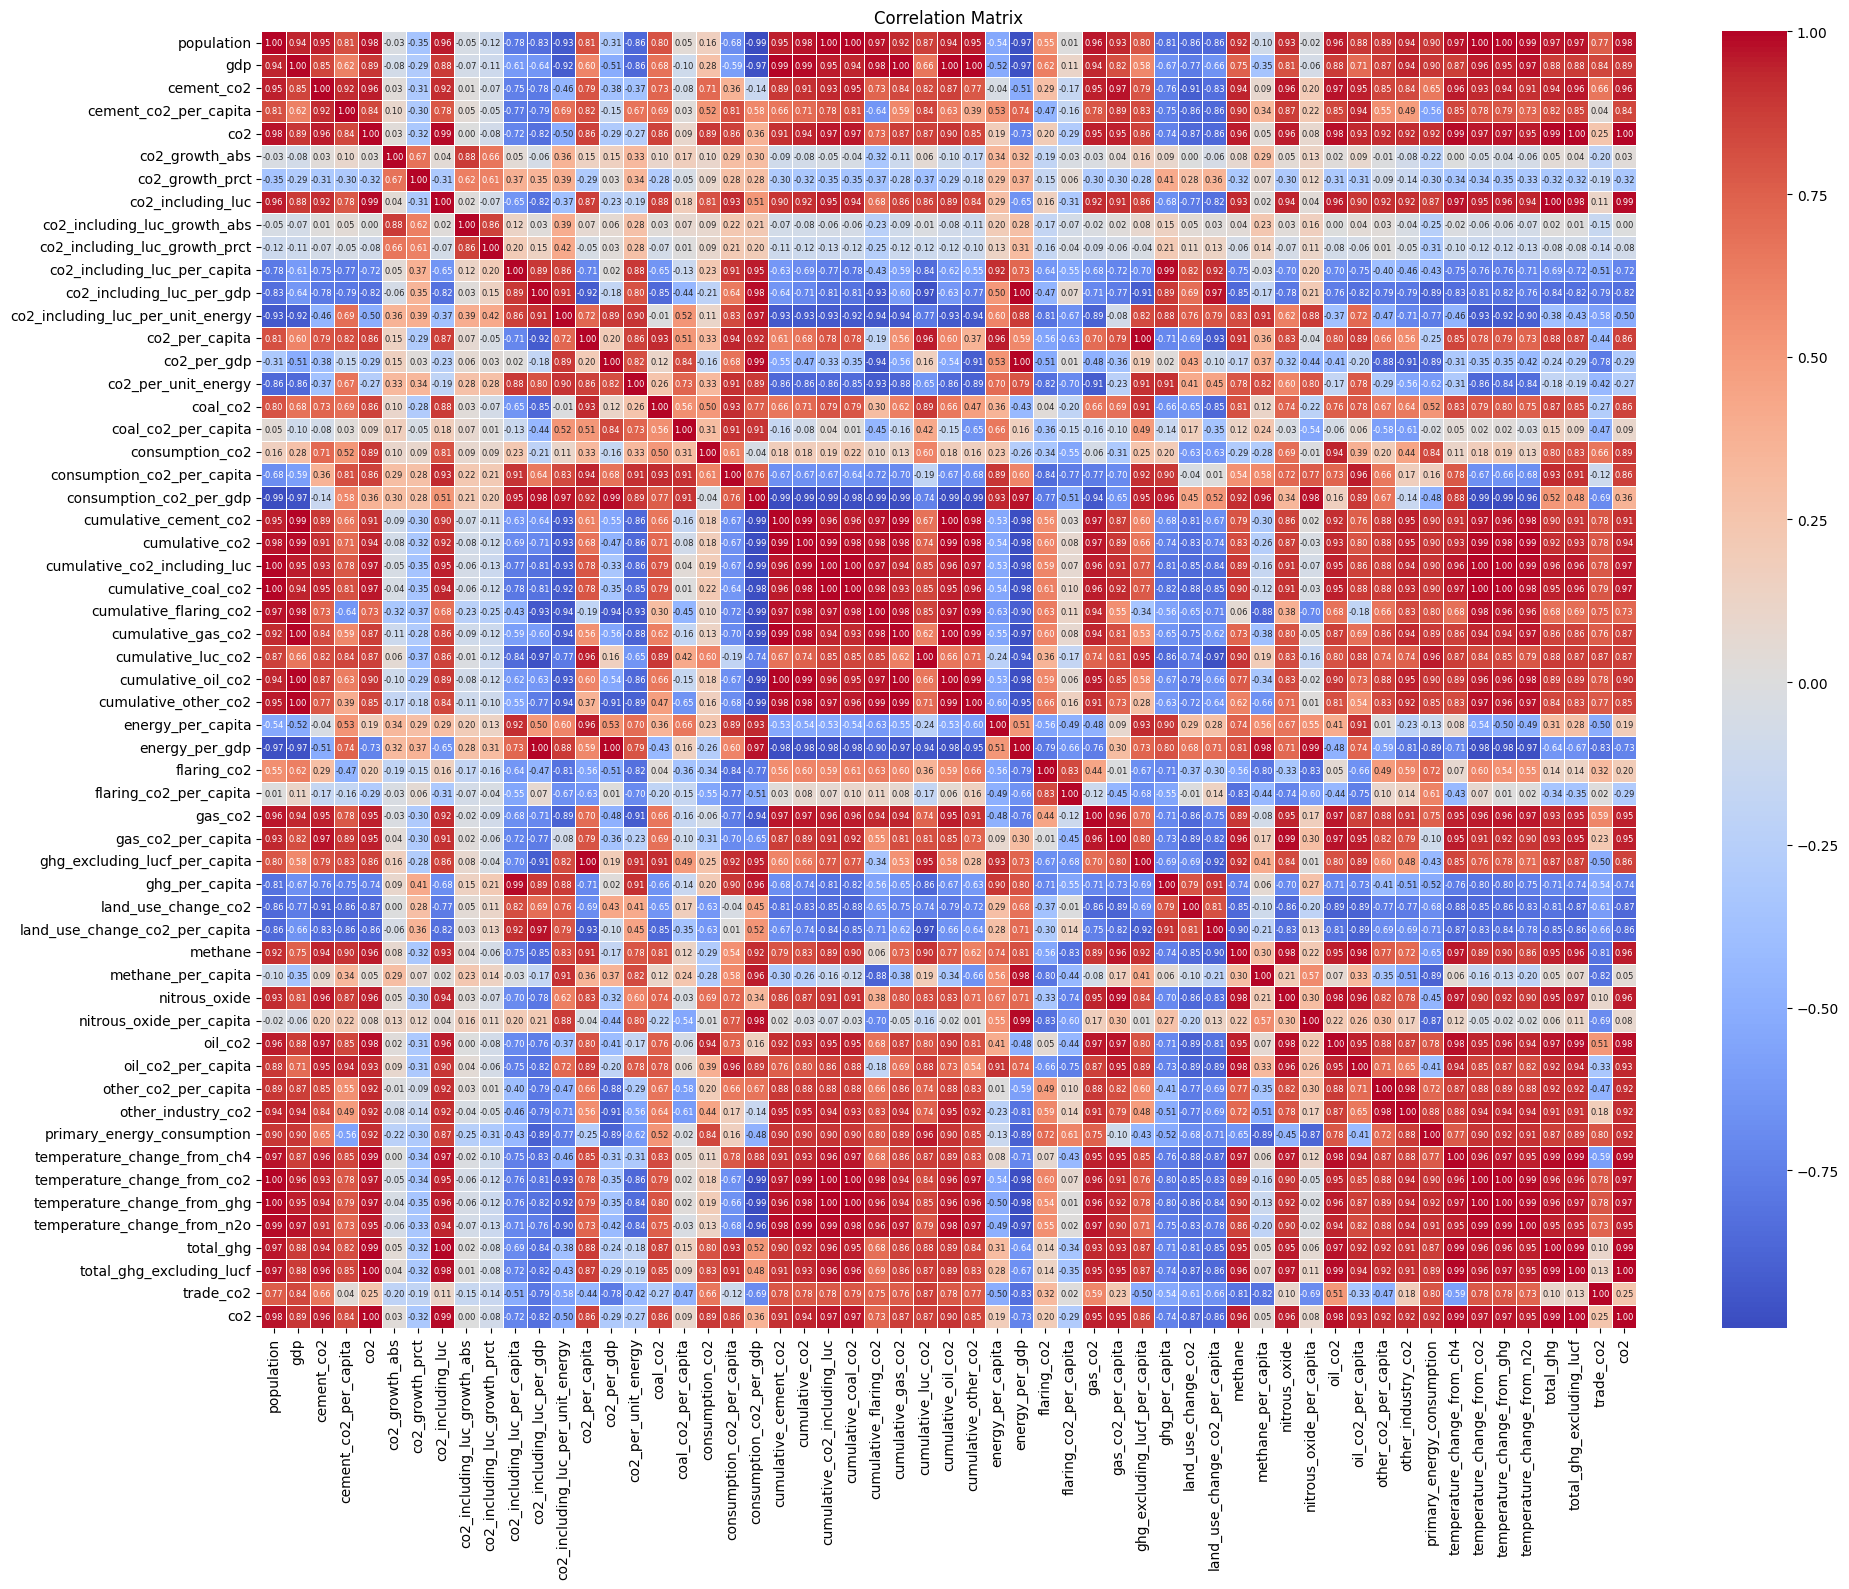

Highly correlated feature pairs:
                        Feature 1                    Feature 2  Correlation
146                           co2                          co2     1.000000
387  cumulative_co2_including_luc  temperature_change_from_co2     0.999947
145                           co2     total_ghg_excluding_lucf     0.999470
656      total_ghg_excluding_lucf                          co2     0.999470
388  cumulative_co2_including_luc  temperature_change_from_ghg     0.999191
..                            ...                          ...          ...
306       consumption_co2_per_gdp           cumulative_oil_co2    -0.989279
304       consumption_co2_per_gdp       cumulative_flaring_co2    -0.989419
307       consumption_co2_per_gdp         cumulative_other_co2    -0.991549
305       consumption_co2_per_gdp           cumulative_gas_co2    -0.991633
10                     population      consumption_co2_per_gdp    -0.991635

[657 rows x 3 columns]

Variance Inflation Factors:
  

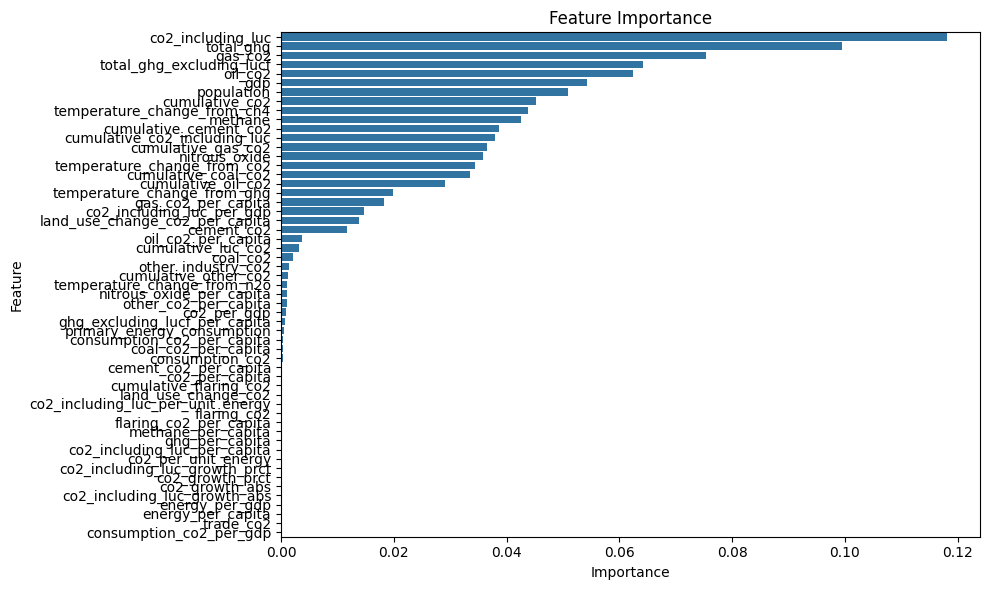

In [4]:
analyze_selected_features(csv_file,[

    'population', 'gdp',
    'cement_co2', 'cement_co2_per_capita',
    'co2', 'co2_growth_abs', 'co2_growth_prct',
    'co2_including_luc', 'co2_including_luc_growth_abs', 'co2_including_luc_growth_prct',
    'co2_including_luc_per_capita', 'co2_including_luc_per_gdp', 'co2_including_luc_per_unit_energy',
    'co2_per_capita', 'co2_per_gdp', 'co2_per_unit_energy',
    'coal_co2', 'coal_co2_per_capita',
    'consumption_co2', 'consumption_co2_per_capita', 'consumption_co2_per_gdp',
    'cumulative_cement_co2', 'cumulative_co2', 'cumulative_co2_including_luc',
    'cumulative_coal_co2', 'cumulative_flaring_co2', 'cumulative_gas_co2',
    'cumulative_luc_co2', 'cumulative_oil_co2', 'cumulative_other_co2',
    'energy_per_capita', 'energy_per_gdp',
    'flaring_co2', 'flaring_co2_per_capita',
    'gas_co2', 'gas_co2_per_capita',
    'ghg_excluding_lucf_per_capita', 'ghg_per_capita',
    'land_use_change_co2', 'land_use_change_co2_per_capita',
    'methane', 'methane_per_capita',
    'nitrous_oxide', 'nitrous_oxide_per_capita',
    'oil_co2', 'oil_co2_per_capita',
    'other_co2_per_capita', 'other_industry_co2',
    'primary_energy_consumption',
    'temperature_change_from_ch4', 'temperature_change_from_co2',
    'temperature_change_from_ghg', 'temperature_change_from_n2o',
    'total_ghg', 'total_ghg_excluding_lucf',
    'trade_co2'
],target_variable='co2')

In [14]:
csv_file = r"C:\Users\acksh\OneDrive\Desktop\MSAI\Machine Learning\Final_project\data\raw_data\databycountry\United_states.csv"
df= pd.read_csv(csv_file)

selected_features = [
    "year",
    "coal_co2",
    "coal_co2_per_capita",
    "oil_co2",
    "oil_co2_per_capita",
    "gas_co2",
    "gas_co2_per_capita",
    "cement_co2",
    "cement_co2_per_capita",
    "flaring_co2",
    "flaring_co2_per_capita",
    "land_use_change_co2",
    "land_use_change_co2_per_capita",
    "ghg_per_capita",
    "ghg_excluding_lucf_per_capita",
    "total_ghg",
    "total_ghg_excluding_lucf",
    "methane",
    "nitrous_oxide",
    # Retained Direct Features
    "primary_energy_consumption",
    "energy_per_capita",
    "co2_per_unit_energy",
    "co2_including_luc",       # Optional, based on modeling choice
    "other_industry_co2","co2"
]
print(len(df))
df= df[selected_features]
df.isnull().sum()

174


year                                0
coal_co2                            0
coal_co2_per_capita                 0
oil_co2                             0
oil_co2_per_capita                  0
gas_co2                             0
gas_co2_per_capita                  0
cement_co2                          0
cement_co2_per_capita               0
flaring_co2                       100
flaring_co2_per_capita            100
land_use_change_co2                 0
land_use_change_co2_per_capita      0
ghg_per_capita                      0
ghg_excluding_lucf_per_capita       0
total_ghg                           0
total_ghg_excluding_lucf            0
methane                             0
nitrous_oxide                       0
primary_energy_consumption        115
energy_per_capita                 115
co2_per_unit_energy               115
co2_including_luc                   0
other_industry_co2                 54
co2                                 0
dtype: int64